<a href="https://colab.research.google.com/github/an-eve/restricted-bolzmann-machine/blob/main/dbn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST Exploration with Deep Belief Networks (DBN)

Author: Anna Putina
2081379

Cognition and Computation

## Imports and Dataset Uploading

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/an-eve/restricted-bolzmann-machine/main/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [5]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import torchvision.transforms as transforms
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras


from DBN import DBN

Choose GPU when available

In [4]:
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

True
cuda


Uploading **Fasion MNIST** dataset:

The dataset is a collection of 70,000 grayscale images (28x28 pixels) of clothing items, designed as a drop-in replacement for the classic MNIST dataset. It consists of 10 classes, including items like T-shirts, trousers, dresses, and sneakers, with 60,000 images for training and 10,000 for testing.

In [12]:
# Load Fashion-MNIST dataset
fsh_mnist_train = tv.datasets.FashionMNIST(root="./data", train=True, download=True)
fsh_mnist_test = tv.datasets.FashionMNIST(root="./data", train=False, download=True)

# Move data to the selected device
train_images = fsh_mnist_train.data.to(dtype=torch.float32, device=device) / 255
test_images = fsh_mnist_test.data.to(dtype=torch.float32, device=device) / 255

train_labels = fsh_mnist_train.targets.to(device)
test_labels = fsh_mnist_test.targets.to(device)

# Print dataset shapes
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: torch.Size([60000, 28, 28])
Test images shape: torch.Size([10000, 28, 28])
Train labels shape: torch.Size([60000])
Test labels shape: torch.Size([10000])


Show some samples

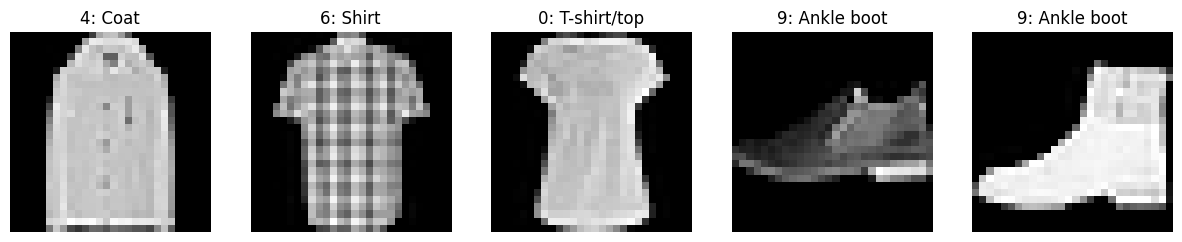

In [13]:
# Class labels for Fashion-MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

num_samples = 5
indices = torch.randint(0, train_images.shape[0], (num_samples,))

sample_images = train_images[indices].cpu().numpy()
sample_labels = train_labels[indices].cpu().numpy()

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    axes[i].imshow(sample_images[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{sample_labels[i]}: {class_labels[sample_labels[i]]}")

plt.show()

## Deep Belief Network

A Deep Belief Network (DBN) is a type of deep neural network composed of multiple stacked Restricted Boltzmann Machines (RBMs), where each layer learns a probabilistic representation of the input in an unsupervised manner. Once pretraining is complete, the DBN can be fine-tuned using supervised learning techniques.

In [14]:
dbn_fashion = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=[400, 600, 900], # size of hidden layers
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.4,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Training the model

In [17]:
num_epochs = 80
batch_size = 125

dbn_fashion.train_static(
    train_images,
    train_labels,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6774     |0.0765       |289.8587   |5.6568     |
|20    |1.6739     |0.0749       |288.4945   |6.0270     |
|30    |1.6720     |0.0775       |286.1731   |5.8561     |
|40    |1.6680     |0.0771       |284.6693   |4.7682     |
|50    |1.6680     |0.0755       |283.2845   |5.6127     |
|60    |1.6681     |0.0748       |281.9149   |4.9057     |
|70    |1.6699     |0.0760       |281.6284   |5.3343     |
|80    |1.6691     |0.0758       |279.1823   |4.6863     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0804     |0.0367       |147.6712   |2.4238     |
|20    |0.9992     |0.0331       |135.2118   |2.3072     |
|30    |0.9823     |0.0335       |132.9781   |2.2297     |
|40    |0.9729     |0.0335       |130.7548   |1.8917     |
|50    |0.9667     |0.0321       |129.2577   |2.1659     |
|60    |0.9659     |0.0314       

## Visualizing receptive fields

After training a Deep Belief Network (DBN), the learned weights between the input and hidden layers represent the features the model has detected. Visualizing these receptive fields as grayscale images helps us understand what patterns or parts of an image activate specific neurons, aiding in feature analysis, debugging, and model improvement.

To do this, we extract the weight vectors, reshape them into the same size as input images (28×28 for Fashion-MNIST), and plot them. Since different neurons may learn weights at varying scales, we normalize them using MinMaxScaler to ensure comparability, and applying a threshold can reduce noise and highlight key features.

For deeper hidden layers, the weights do not have the same dimensionality as the input images. To visualize them, we must project these weight vectors into a 784-dimensional space (28×28). There are multiple ways to do this; for simplicity, we use a linear projection to map these higher-layer weights back to the input space, making them interpretable as images.

In [18]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

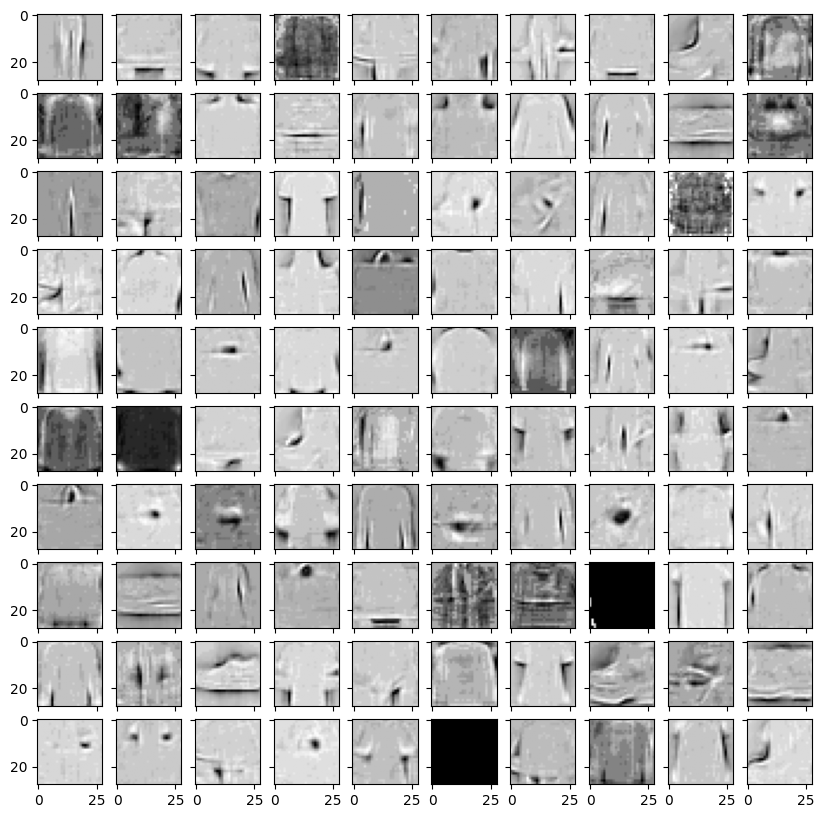

In [21]:
w1 = get_weights(dbn_fashion, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

Hidden layers

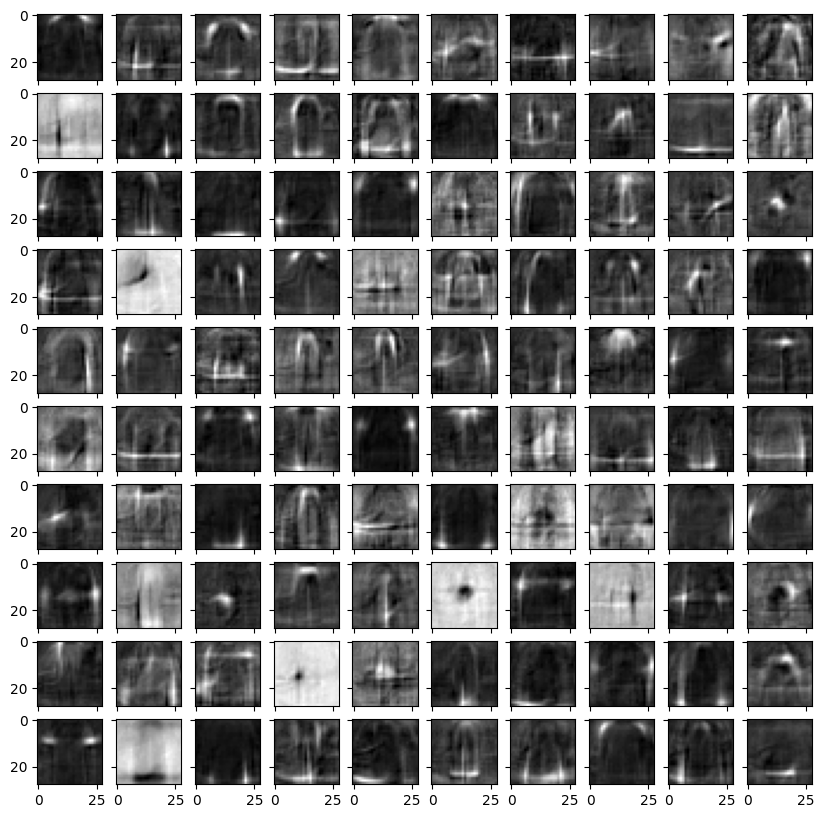

In [22]:
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

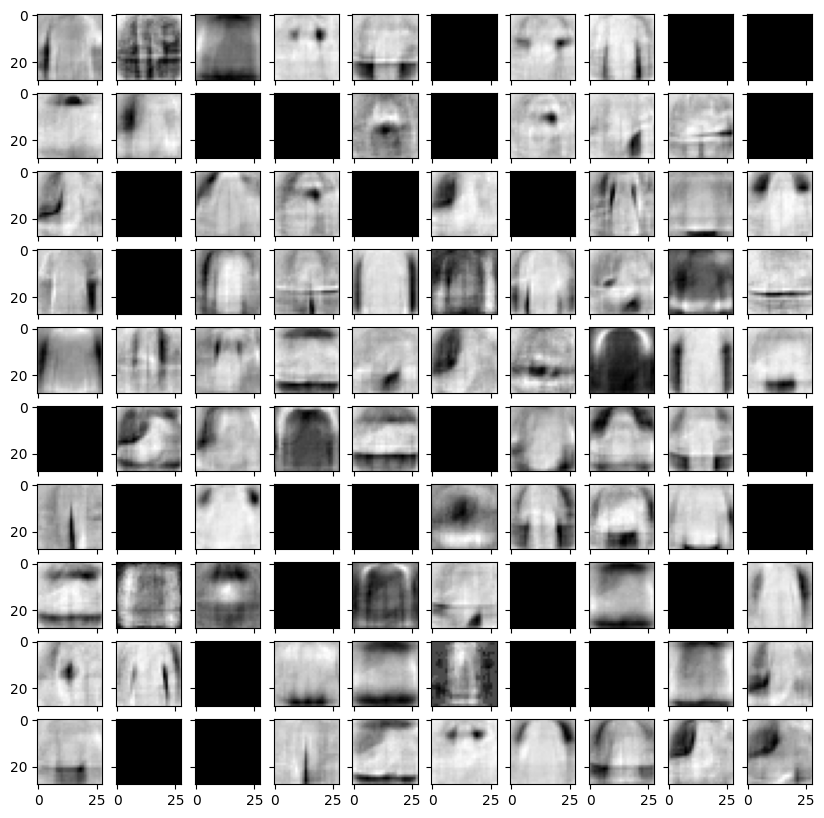

In [23]:
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)
w3 = get_weights(dbn_fashion, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

## Clustering internal representations

After training a Deep Belief Network (DBN), we analyze how it organizes different classes by clustering their internal representations. Instead of using individual activations, we compute centroids (mean activations) for each class, reducing noise and summarizing the learned features.

To visualize class relationships, we apply hierarchical clustering and represent the results using a dendrogram. This shows which classes have similar feature representations—closely clustered classes share learned patterns, while distant ones indicate distinct features. If expected groups (e.g., "Sneaker" and "Ankle Boot") cluster together, the DBN has captured meaningful similarities. If unrelated classes are close, it may suggest confusion in feature learning. This analysis helps evaluate and refine the model's feature representations.

In [24]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashion.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [25]:
hidden_repr_1 = get_kth_layer_repr(train_images, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 400])
torch.Size([60000, 600])
torch.Size([60000, 900])


In [27]:
def get_mask(label):  # we use this function to filter by class
  labels = train_labels.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

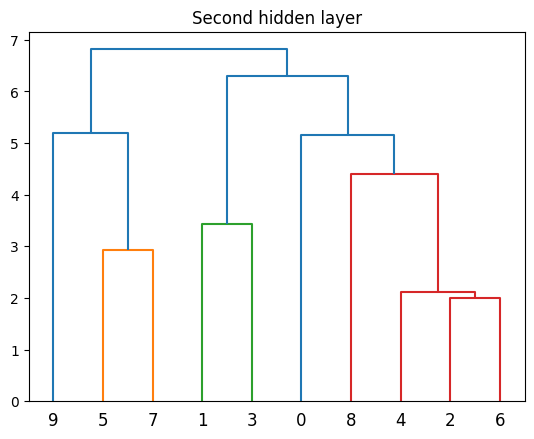

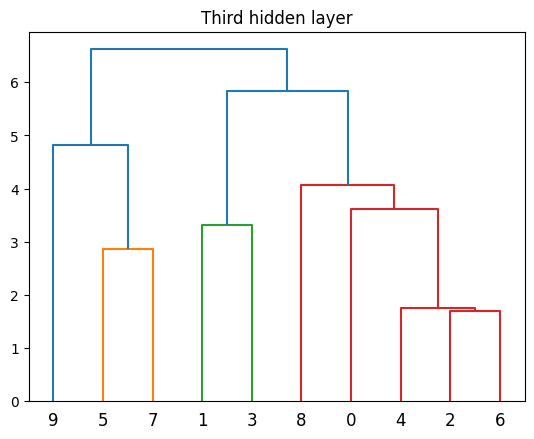

In [30]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

plot_dendrogram(mean_hidd_repr_matrix_2, 'Second hidden layer')
plot_dendrogram(mean_hidd_repr_matrix_3, 'Third hidden layer')

In [36]:
# Function to show closest clusters
def plot_cluster_examples(cluster_classes, num_examples=5):
    fig, axes = plt.subplots(2, num_examples, figsize=(10, 5))

    for row, class_label in enumerate(cluster_classes):
        mask = get_mask(class_label)  # Get all images of the class
        class_images = train_images[mask][:num_examples].cpu().numpy()  # Take some examples

        print(f"Class {class_label}: {class_labels[class_label]}")  # Print class name

        for col in range(num_examples):
            axes[row, col].imshow(class_images[col], cmap="gray")
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].set_title(f"{class_labels[class_label]} ({class_label})")

    plt.show()


Class 2: Pullover
Class 6: Shirt


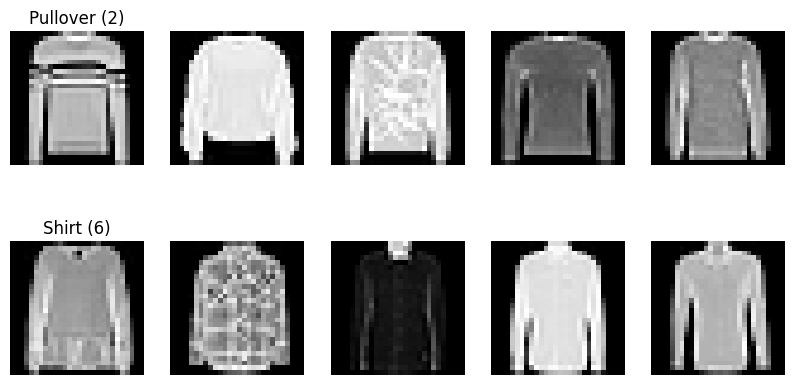

In [37]:
plot_cluster_examples([2, 6], num_examples=5)

Class 5: Sandal
Class 7: Sneaker


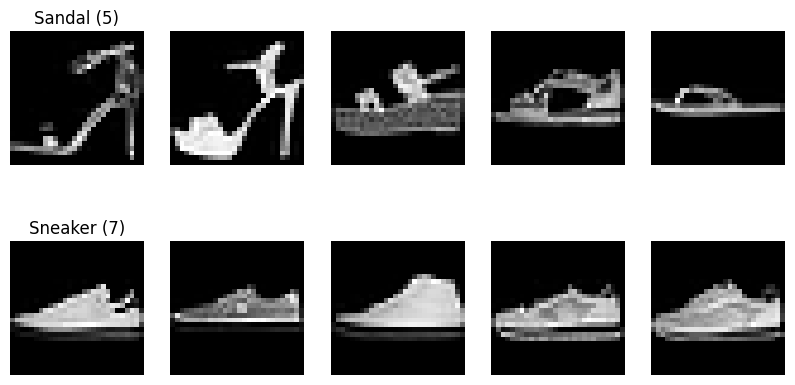

In [39]:
plot_cluster_examples([5, 7], num_examples=5)

Indead, we see that the closest clusters represent similar items.

## Linear read-out

A linear readout is a technique to assess the quality of hidden representations in a Deep Belief Network (DBN) by training a simple linear classifier on them. If the classifier achieves high accuracy, it indicates that the hidden layer retains meaningful and discriminative features for classification.

To apply this, we compute activations at each hidden layer and use them as input for a linear classifier. If accuracy improves with deeper layers, the DBN is effectively extracting useful features. A drop in accuracy at later layers may suggest that representations become too abstract or lose discriminative power. This method provides a quick way to evaluate whether each layer contributes to meaningful feature learning.

In [40]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [41]:
layer_size = dbn_fashion.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Training

In [55]:
def train_linear(linear, hidden_reprs, epochs = 1000):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = train_labels.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [44]:
train_linear(linear1, hidden_repr_1)
train_linear(linear2, hidden_repr_2)
train_linear(linear3, hidden_repr_3)


epoch :   1/1000, loss = 2.2889
epoch : 101/1000, loss = 0.9261
epoch : 201/1000, loss = 0.7258
epoch : 301/1000, loss = 0.6439
epoch : 401/1000, loss = 0.5968
epoch : 501/1000, loss = 0.5651
epoch : 601/1000, loss = 0.5419
epoch : 701/1000, loss = 0.5238
epoch : 801/1000, loss = 0.5092
epoch : 901/1000, loss = 0.4972
epoch :   1/1000, loss = 2.2822
epoch : 101/1000, loss = 0.8021
epoch : 201/1000, loss = 0.6517
epoch : 301/1000, loss = 0.5897
epoch : 401/1000, loss = 0.5529
epoch : 501/1000, loss = 0.5276
epoch : 601/1000, loss = 0.5087
epoch : 701/1000, loss = 0.4939
epoch : 801/1000, loss = 0.4819
epoch : 901/1000, loss = 0.4720
epoch :   1/1000, loss = 2.3261
epoch : 101/1000, loss = 0.8697
epoch : 201/1000, loss = 0.6829
epoch : 301/1000, loss = 0.6086
epoch : 401/1000, loss = 0.5663
epoch : 501/1000, loss = 0.5379
epoch : 601/1000, loss = 0.5172
epoch : 701/1000, loss = 0.5012
epoch : 801/1000, loss = 0.4883
epoch : 901/1000, loss = 0.4778


Evaluation

In [45]:
hidden_repr_1_test = get_kth_layer_repr(train_images, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [46]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [49]:
print(compute_accuracy(predictions_test1, train_labels))
print(compute_accuracy(predictions_test2, train_labels))
print(compute_accuracy(predictions_test3, train_labels))

0.8369666934013367
0.8397166728973389
0.8393499851226807


The slight accuracy increase (**0.837 → 0.840 → 0.839**) suggests that deeper layers provide **minimal additional disentanglement**. Most useful features are learned early, and deeper layers do not significantly improve class separability. This indicates that the DBN may not be refining representations effectively at deeper levels. Further analysis or architectural adjustments may be needed to enhance hierarchical feature learning.

## Comparison with a feed-forward neural network

This comparison tests **unsupervised pretraining (DBN + linear classifier)** against **end-to-end supervised learning (FNN)**. It evaluates whether the **DBN’s learned representations** are as effective as those learned **directly through supervision**. A stronger DBN suggests unsupervised learning captures meaningful features, while a better FNN indicates direct supervision is more beneficial.

In [50]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [51]:
ffnn = Feedforward(400, 600, 900).to(device)

In [56]:
train_linear(ffnn, train_images.reshape((60000, 784)), 1000)

epoch :   1/1000, loss = 2.3040
epoch : 101/1000, loss = 1.4011
epoch : 201/1000, loss = 0.9126
epoch : 301/1000, loss = 0.7607
epoch : 401/1000, loss = 0.6743
epoch : 501/1000, loss = 0.6131
epoch : 601/1000, loss = 0.5668
epoch : 701/1000, loss = 0.5409
epoch : 801/1000, loss = 0.5149
epoch : 901/1000, loss = 0.4955


In [57]:
predictions_ffnn = ffnn(test_images.reshape((10000, 784)))
compute_accuracy(predictions_ffnn, test_labels)

0.8157999515533447

The accuracy is a little lower for FFNN.

Confusion matrixes for models:

In [61]:
def plot_confusion_matrix(model, data, targets, model_type="FFNN", layer=0):
    """Plots the confusion matrix for FFNN or DBN models."""

    # Reshape input data appropriately
    if model_type == "FFNN":
        predictions = model(data.reshape((data.shape[0], 784)))  # Flatten for FFNN
    elif model_type == "DBN":
        predictions, _ = model.rbm_layers[layer].to_hidden(data.view(data.shape[0], -1))  # DBN hidden transformation

    # Convert probabilities to predicted class indices
    predictions = predictions.max(axis=1).indices

    # Compute confusion matrix
    conf_mat = confusion_matrix(
        targets.cpu().numpy(),
        predictions.cpu().detach().numpy(),
        labels=np.unique(targets.cpu().numpy()),
        normalize='true'
    )

    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt='.2f',
        xticklabels=np.unique(targets.cpu().numpy()),
        yticklabels=np.unique(targets.cpu().numpy())
    )
    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.title(f'Confusion Matrix - {model_type}', fontsize=18)
    plt.show()

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data, targets, model_type="FFNN", dbn_layer=None):
    """Plots the confusion matrix for FFNN or DBN models, allowing DBN layer selection."""

    # Reshape and process data based on model type
    if model_type == "FFNN":
        predictions = model(data.reshape((data.shape[0], 784)))  # Flatten for FFNN

    elif model_type == "DBN":
        if dbn_layer is None:
            raise ValueError("For DBN, you must specify dbn_layer as 0, 1, or 2.")

        # Compute the hidden representation at the specified DBN layer
        data = data.view(data.shape[0], -1)
        if dbn_layer == 0:
            hidden_repr, _ = model.rbm_layers[0].to_hidden(data)
            predictions = linear1(hidden_repr)
        elif dbn_layer == 1:
            hidden_repr_1, _ = model.rbm_layers[0].to_hidden(data)
            hidden_repr, _ = model.rbm_layers[1].to_hidden(hidden_repr_1)
            predictions = linear2(hidden_repr)
        elif dbn_layer == 2:
            hidden_repr_1, _ = model.rbm_layers[0].to_hidden(data)
            hidden_repr_2, _ = model.rbm_layers[1].to_hidden(hidden_repr_1)
            hidden_repr, _ = model.rbm_layers[2].to_hidden(hidden_repr_2)
            predictions = linear3(hidden_repr)
        else:
            raise ValueError("Invalid dbn_layer. Choose 0, 1, or 2.")

    # Convert probabilities to predicted class indices
    predictions = predictions.max(axis=1).indices

    # Compute confusion matrix
    conf_mat = confusion_matrix(
        targets.cpu().numpy(),
        predictions.cpu().detach().numpy(),
        labels=np.unique(targets.cpu().numpy()),
        normalize='true'
    )

    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt='.2f',
        xticklabels=np.unique(targets.cpu().numpy()),
        yticklabels=np.unique(targets.cpu().numpy())
    )

    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    title = f'Confusion Matrix - {model_type}' if model_type == "FFNN" else f'Confusion Matrix - DBN ({dbn_layer})'
    plt.title(title, fontsize=18)
    plt.show()

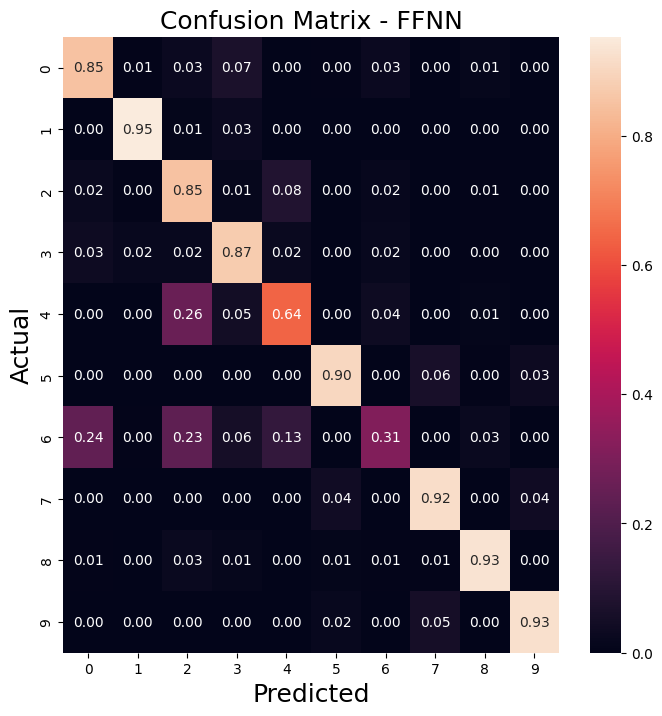

In [65]:
plot_confusion_matrix(ffnn, test_images, test_labels, model_type="FFNN")  # For FFNN

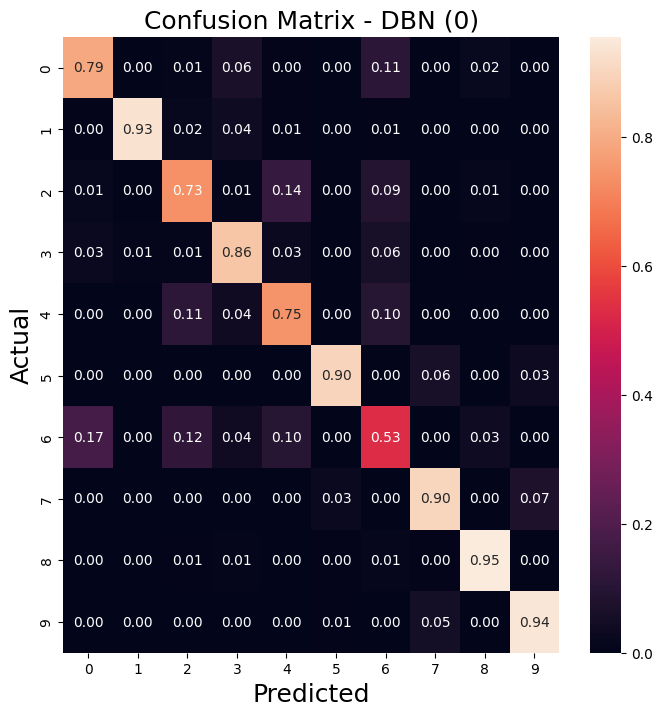

In [66]:
plot_confusion_matrix(dbn_fashion, test_images, test_labels, model_type="DBN", dbn_layer=0)  # For DBN

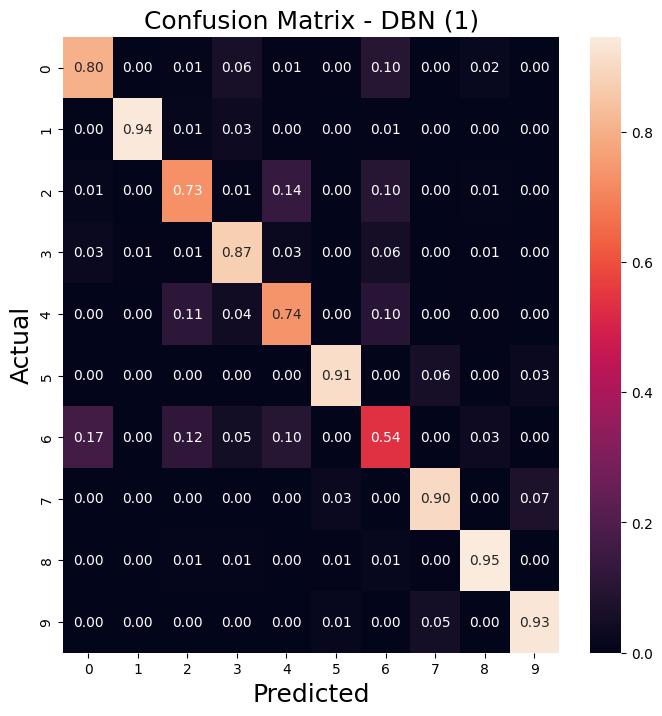

In [67]:
plot_confusion_matrix(dbn_fashion, test_images, test_labels, model_type="DBN", dbn_layer=1)  # For DBN

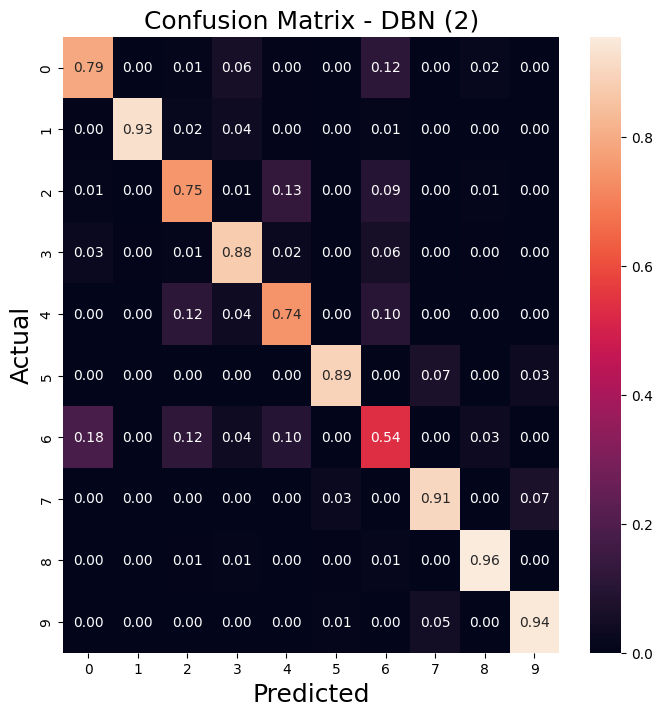

In [68]:
plot_confusion_matrix(dbn_fashion, test_images, test_labels, model_type="DBN", dbn_layer=2)  # For DBN

A confusion matrix compares actual and predicted labels, showing how well a model distinguishes classes. The diagonal values indicate correct predictions, while off-diagonal values highlight misclassifications.

For FFNN vs. DBN layers, deeper DBN layers should improve accuracy if representations become more disentangled. If FFNN outperforms DBN, end-to-end supervised learning is more effective. Large misclassifications suggest overlapping features between classes, helping identify model weaknesses.

## Robustness to noise

Testing robustness to noise evaluates how well a model maintains classification accuracy when the input data is perturbed. By injecting noise into images, we assess whether the DBN and FFNN have learned stable and meaningful representations or if their predictions degrade quickly with minor distortions.

This mimics psychophysical experiments, where human perception is tested under uncertain conditions. By plotting a psychometric curve, we measure how classification accuracy decreases as noise increases. A more gradual decline indicates greater robustness, meaning the model relies on essential features rather than fragile details.

In [82]:
def inject_noise(data, noise_level):
    noise = torch.randn_like(data) * noise_level
    noisy_data = data + noise
    return noisy_data

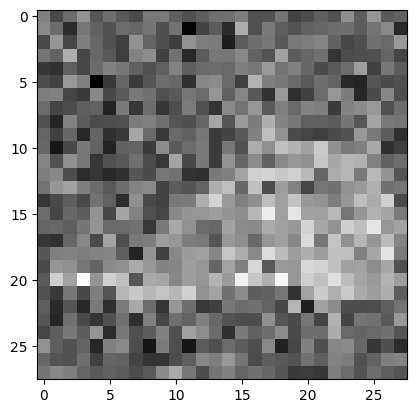

In [83]:
noise_level = 0.3
mnist_test_with_noise = inject_noise(test_images, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

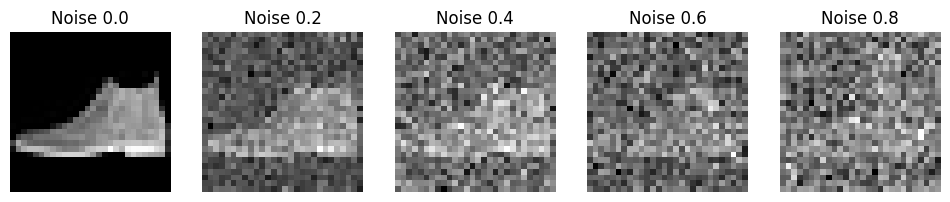

In [84]:
# Define different noise levels
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

# Plot images with increasing noise
fig, axes = plt.subplots(1, len(noise_levels), figsize=(12, 3))

for i, noise_level in enumerate(noise_levels):
    noisy_images = inject_noise(test_images, noise_level)
    axes[i].imshow(noisy_images[0].reshape(28, 28).cpu(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Noise {noise_level}")

plt.show()


We will now generate hidden representations for the noisy images using the DBN. Then, we will classify these noisy inputs using the read-out classifiers that were trained on noise-free representations.

In [85]:
def get_accuracy_values_at_noise_level(noise_level):

  data_test_with_noise = inject_noise(test_images, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(data_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, test_labels)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, test_labels)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, test_labels)

  ### TASK: repeat a similar process for the feed-forward model (NB: make sure you reshape the input data appropriately!)
  predictions_ffnn_noisy = ffnn(data_test_with_noise.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, test_labels)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn


In [86]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.799
Accuracy of H2 read-out: 0.813
Accuracy of H3 read-out: 0.816
Accuracy of FF network : 0.785


Check different noise levels:

In [87]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

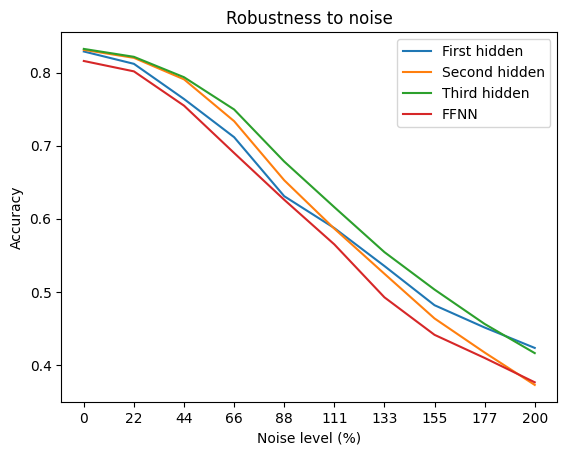

In [89]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

As noise increases, classification accuracy drops for all models. Deeper DBN layers (green, orange) are more robust, while FFNN (red) degrades faster, showing higher sensitivity to noise. At extreme noise levels, all models perform similarly. This suggests unsupervised pretraining (DBN) learns more stable features, making it more resilient to noise.